In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display, Markdown
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install sentence_transformers annoy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cac

In [4]:
# Load necessary libraries
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [6]:
# Load the data into pandas dataframes
topics_df = pd.read_csv('//content/drive/MyDrive/learning-equality-curriculum-recommendations/topics.csv', index_col=0).fillna({"title": "", "description": ""})
topics_df = topics_df[topics_df['language'] == 'en']
content_df = pd.read_csv('/content/drive/MyDrive/learning-equality-curriculum-recommendations/content.csv', index_col=0).fillna("")
content_df = content_df[content_df['language'] == 'en']
correlations_df = pd.read_csv('/content/drive/MyDrive/learning-equality-curriculum-recommendations/correlations.csv', index_col=0)

# Filter topics that have content
topics_df = topics_df[topics_df['has_content']]

In [7]:

# Define helper functions and classes
class Topic:
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" >> ", include_self=True, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"

class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title

    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

In [8]:
# Initialize the sentence transformer model
# model = SentenceTransformer("all-mpnet-base-v2")
# Using different models for comparison
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")
# model = SentenceTransformer("paraphrase-MiniLM-L6-v2")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [9]:
# Embedding topics
print("Embedding topics...")
topic_embeddings = model.encode([f"{row['title']} - {row['description']}" for idx, row in topics_df.iterrows()])

# Embedding content
print("Embedding content...")
content_embeddings = model.encode([row['title'] for idx, row in content_df.iterrows()])

Embedding topics...
Embedding content...


In [11]:
# Prepare data for training
X = np.vstack((topic_embeddings, content_embeddings))
y = np.concatenate((np.ones(len(topic_embeddings)), np.zeros(len(content_embeddings))))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize k-NN classifier
knn_model = KNeighborsClassifier(n_neighbors=4)

# Train the model
print("Training k-NN model...")
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

Training k-NN model...


In [12]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8503111867652535
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     13262
         1.0       0.85      0.60      0.70      5537

    accuracy                           0.85     18799
   macro avg       0.85      0.78      0.80     18799
weighted avg       0.85      0.85      0.84     18799

Confusion Matrix:
[[12665   597]
 [ 2217  3320]]


In [13]:
!pip install matplotlib seaborn
import seaborn as sns

Accuracy: 0.8503111867652535


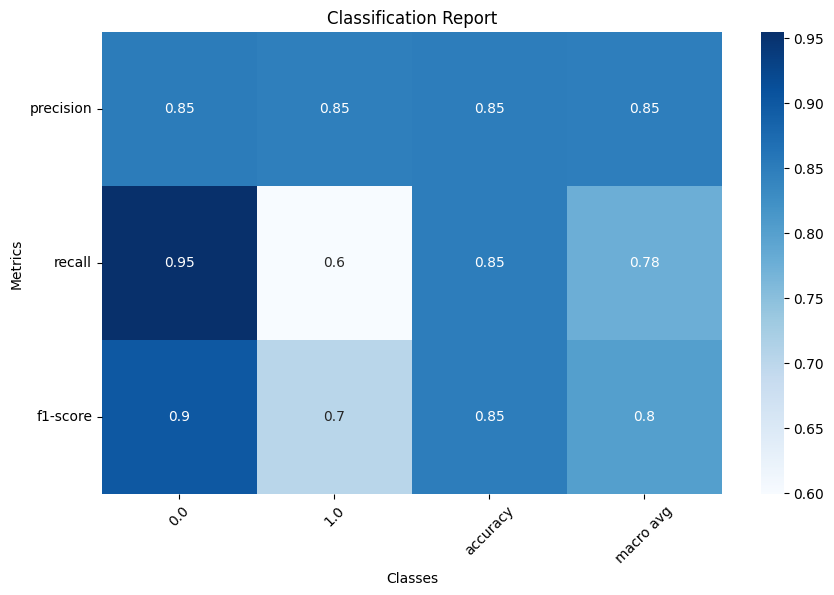

In [14]:

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert evaluation results to tables
def plot_classification_report(report):
    report_df = pd.DataFrame(report).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Topic'], yticklabels=['Content', 'Topic'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

print(f'Accuracy: {accuracy}')
plot_classification_report(report_dict)
#

# Save the trained model to a file

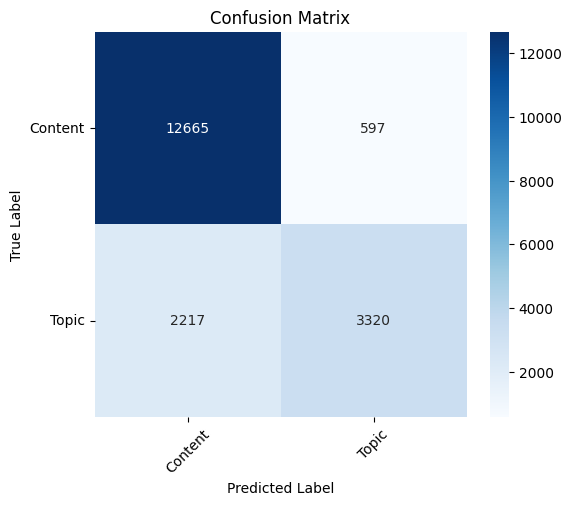

In [15]:
plot_confusion_matrix(conf_matrix)

In [16]:
# Save the trained model to a file
joblib.dump(knn_model, 'knn_model.joblib')

# Load the trained model
knn_model = joblib.load('knn_model.joblib')

In [17]:
# Define recommendation function using k-NN
def recommend_content(topic_id, knn_model, model):
    # Get the embedding for the given topic_id
    topic_embedding = model.encode(f"{topics_df.loc[topic_id]['title']} - {topics_df.loc[topic_id]['description']}")

    # Calculate distances between the topic embedding and all content embeddings
    distances = np.linalg.norm(content_embeddings - topic_embedding, axis=1)

    # Get the indices of the closest content
    top_indices = np.argsort(distances)[:4]  # Top 5 recommendations
    recommended_content_ids = content_df.index[top_indices].tolist()

    return recommended_content_ids

# Example usage
def run_recommendation(topic_id):
    recommended_content = recommend_content(topic_id, knn_model, model)
    if recommended_content:
        print(f"Recommended content for Topic ID {topic_id}:")
        print("Topic title:", topics_df.loc[topic_id]["title"])
        print("Recommendations:")
        for content_id in recommended_content:
            print(f"Content ID: {content_id}, Title: {content_df.loc[content_id]['title']}")
    else:
        print(f"No recommendations available for Topic ID {topic_id}")

# Example usage
run_recommendation('t_00069b63a70a')

Recommended content for Topic ID t_00069b63a70a:
Topic title: Transcripts
Recommendations:
Content ID: c_430ddb6fbfa4, Title: Transcription
Content ID: c_07e16f3aabbf, Title: Transcription
Content ID: c_4e2dd41c64ac, Title: Conversions 
Content ID: c_ac592c567023, Title: Transcription - Advanced


In [ ]:
run_recommendation('t_00531bf01fb6')

In [ ]:
recommendations = run_recommendation('t_00069b63a70a')

Recommended content for Topic ID t_00069b63a70a:
Topic title: Transcripts
Recommendations:
Content ID: c_430ddb6fbfa4, Title: Transcription
Content ID: c_07e16f3aabbf, Title: Transcription
Content ID: c_4e2dd41c64ac, Title: Conversions 
Content ID: c_ac592c567023, Title: Transcription - Advanced
Content ID: c_650028746faf, Title: Vertical Translations
